In [44]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'font.size': 19})
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load data
values = []

for i in range (5,10):
    f = h5py.File('../data/ghi_201{}.h5'.format(i), 'r')
    value = f['/set']
    values.append(value)

del values[1] # year 2016 doesn't have the save shape
print(values)

[<HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">]


In [12]:
# Get serie for one coordinate (200,200) :

fifty_days = 50*96 # 50 days

year_2017 = values[1][:,200,200] # year 2017
fifty_days_2017 = values[1][:fifty_days,200,200] # first 50 days of year 2017

print(year_2017.shape)
print(fifty_days_2017.shape)


(35040,)
(4800,)


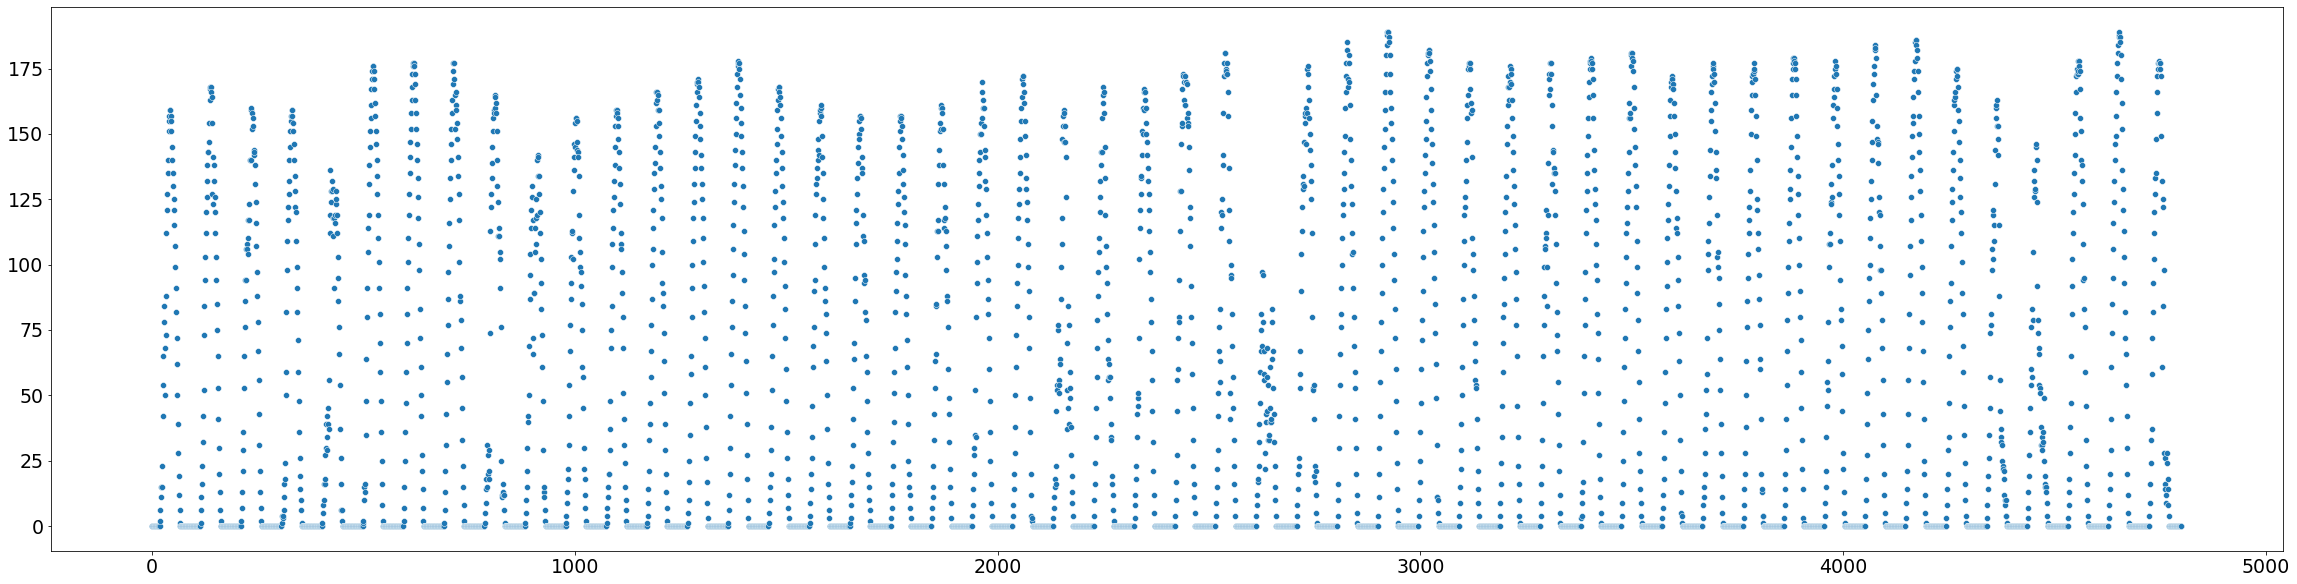

In [13]:
# plot 50 days for this coordinate
fig, ax = plt.subplots(figsize=(40,10))
x=fifty_days_2017
sns.scatterplot(x=list(range(x.shape[0])),y=x,ax=ax);

In [17]:
# Perform necessary test for one coordinate over a year

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [18]:
adfuller_test(year_2017, name="year 2017, coord 200,200")

    Augmented Dickey-Fuller Test on "year 2017, coord 200,200" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -53.4409
 No. Lags Chosen       = 52
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [19]:
# evaluate an ARIMA model with MSE for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in tqdm(range(len(test))):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [22]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [23]:
# Grid search best ARIMA model over 10 days
grid_train = year_2017[:960]
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(grid_train, p_values, d_values, q_values)

100%|██████████| 327/327 [00:33<00:00,  9.64it/s]


ARIMA(0, 0, 0) MSE=3242.879


100%|██████████| 327/327 [00:46<00:00,  7.00it/s]


ARIMA(0, 0, 1) MSE=890.263


100%|██████████| 327/327 [02:09<00:00,  2.53it/s]


ARIMA(0, 0, 2) MSE=357.236


100%|██████████| 327/327 [00:05<00:00, 63.83it/s]


ARIMA(0, 1, 0) MSE=61.107


100%|██████████| 327/327 [00:11<00:00, 28.25it/s]


ARIMA(0, 1, 1) MSE=46.654


100%|██████████| 327/327 [00:16<00:00, 19.53it/s]


ARIMA(0, 1, 2) MSE=45.792


100%|██████████| 327/327 [00:06<00:00, 49.68it/s]


ARIMA(0, 2, 0) MSE=53.621


100%|██████████| 327/327 [00:10<00:00, 29.78it/s]


ARIMA(0, 2, 1) MSE=45.498


100%|██████████| 327/327 [00:20<00:00, 16.26it/s]


ARIMA(0, 2, 2) MSE=43.314


100%|██████████| 327/327 [00:40<00:00,  8.03it/s]


ARIMA(1, 0, 0) MSE=60.895


100%|██████████| 327/327 [00:44<00:00,  7.36it/s]


ARIMA(1, 0, 1) MSE=46.389


100%|██████████| 327/327 [01:07<00:00,  4.84it/s]


ARIMA(1, 0, 2) MSE=45.474


100%|██████████| 327/327 [00:08<00:00, 36.76it/s]


ARIMA(1, 1, 0) MSE=42.526


100%|██████████| 327/327 [00:17<00:00, 18.26it/s]


ARIMA(1, 1, 1) MSE=42.606


100%|██████████| 327/327 [00:28<00:00, 11.53it/s]


ARIMA(1, 1, 2) MSE=41.520


100%|██████████| 327/327 [00:09<00:00, 33.25it/s]


ARIMA(1, 2, 0) MSE=49.800


100%|██████████| 327/327 [00:19<00:00, 16.50it/s]


ARIMA(1, 2, 1) MSE=43.015


100%|██████████| 327/327 [00:24<00:00, 13.41it/s]


ARIMA(1, 2, 2) MSE=43.594


100%|██████████| 327/327 [00:48<00:00,  6.79it/s]


ARIMA(2, 0, 0) MSE=41.959


100%|██████████| 327/327 [01:14<00:00,  4.42it/s]


ARIMA(2, 0, 1) MSE=41.609


100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


ARIMA(2, 0, 2) MSE=39.149


100%|██████████| 327/327 [00:14<00:00, 22.83it/s]


ARIMA(2, 1, 0) MSE=42.502


100%|██████████| 327/327 [00:46<00:00,  6.98it/s]


ARIMA(2, 1, 1) MSE=43.005


100%|██████████| 327/327 [00:44<00:00,  7.42it/s]


ARIMA(2, 1, 2) MSE=41.610


100%|██████████| 327/327 [00:15<00:00, 21.24it/s]


ARIMA(2, 2, 0) MSE=47.243


100%|██████████| 327/327 [00:26<00:00, 12.49it/s]


ARIMA(2, 2, 1) MSE=44.226


100%|██████████| 327/327 [00:42<00:00,  7.78it/s]


ARIMA(2, 2, 2) MSE=43.884


100%|██████████| 327/327 [01:02<00:00,  5.20it/s]


ARIMA(3, 0, 0) MSE=41.777


100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


ARIMA(3, 0, 1) MSE=40.760


100%|██████████| 327/327 [00:20<00:00, 15.66it/s]


ARIMA(3, 1, 0) MSE=42.451


100%|██████████| 327/327 [00:41<00:00,  7.94it/s]


ARIMA(3, 1, 1) MSE=42.290


100%|██████████| 327/327 [00:54<00:00,  6.05it/s]


ARIMA(3, 1, 2) MSE=42.150


100%|██████████| 327/327 [00:18<00:00, 18.12it/s]


ARIMA(3, 2, 0) MSE=47.256


100%|██████████| 327/327 [00:38<00:00,  8.49it/s]


ARIMA(3, 2, 1) MSE=44.246


100%|██████████| 327/327 [01:08<00:00,  4.75it/s]

ARIMA(3, 2, 2) MSE=44.045
Best ARIMA(2, 0, 2) MSE=39.149


In [32]:
# Train over 50 days and predict next 10 days
train = fifty_days_2017
test = year_2017[4801:5760]
history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test))):
	model = ARIMA(history, order=(2,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

100%|██████████| 959/959 [23:11<00:00,  1.45s/it]

Test RMSE: 6.240


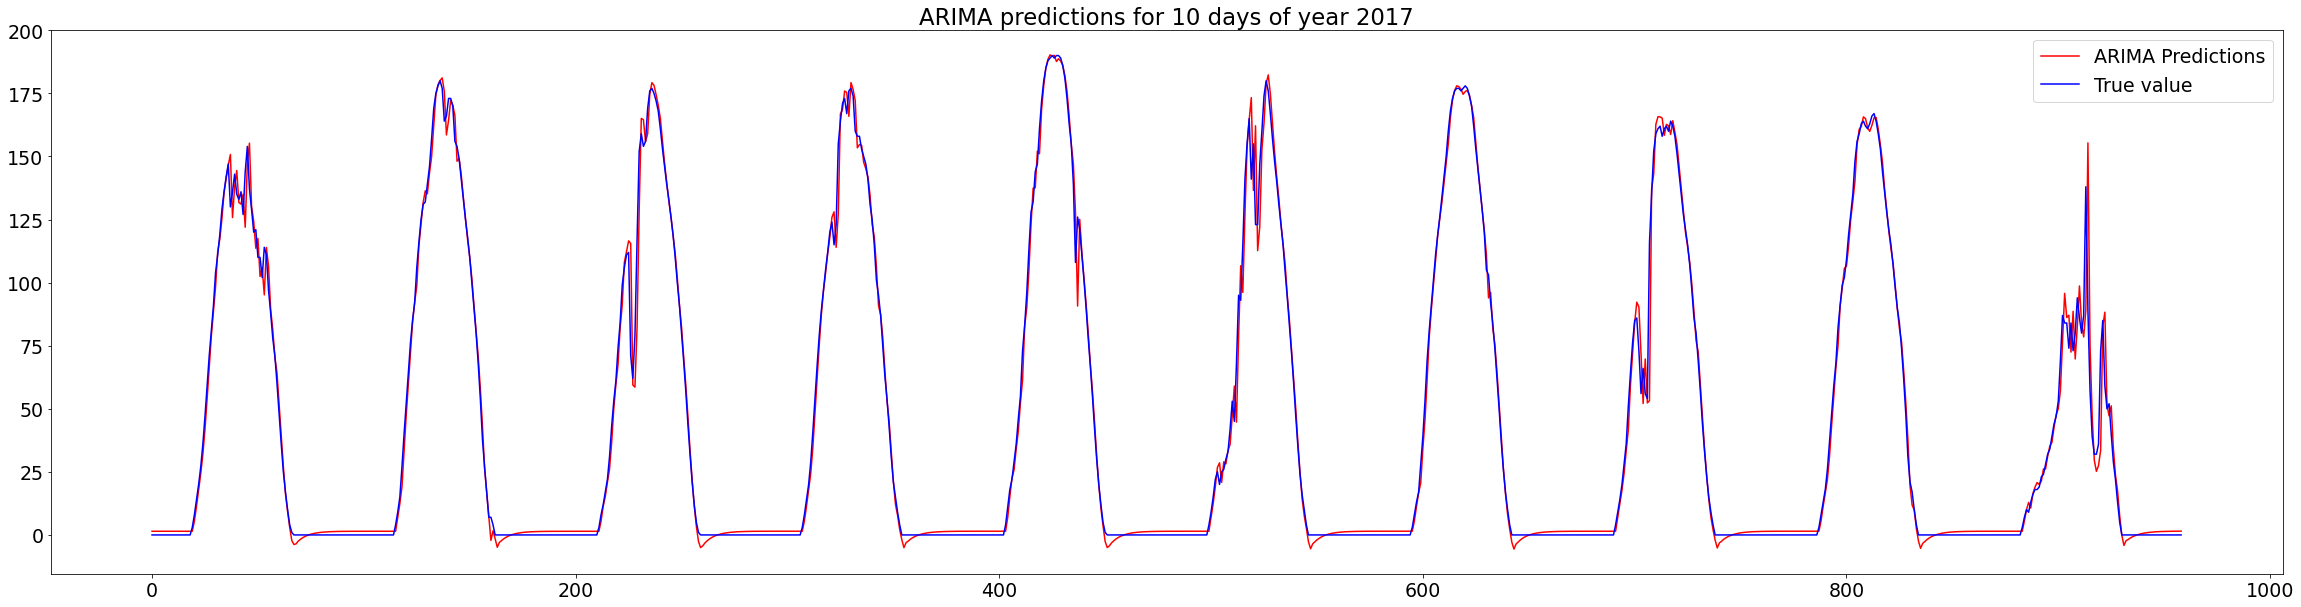

In [35]:
# Plot prediction over 10 days and compare with true value

plt.figure(figsize=(40,10))
plt.plot(predictions, color='Red', label = 'ARIMA Predictions')
plt.plot(test, color= "Blue", label = "True value")
plt.legend()
plt.title('ARIMA predictions for 10 days of year 2017')
plt.show()

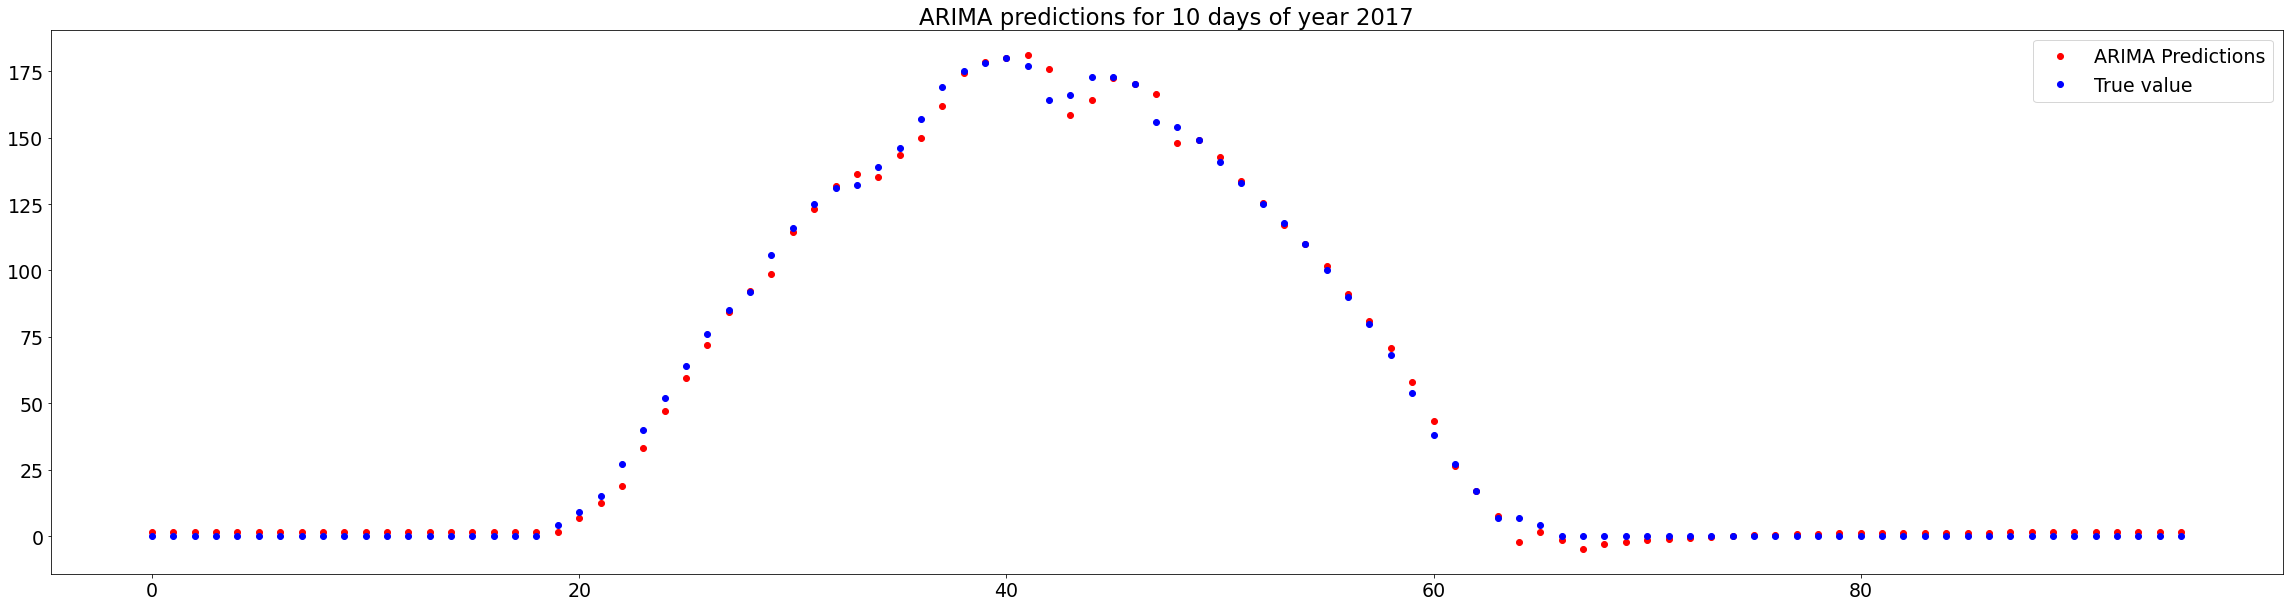

In [43]:
# Zoom over one day

plt.figure(figsize=(40,10))
plt.plot(predictions[96:192],'o', color='Red', label = 'ARIMA Predictions')
plt.plot(test[96:192],'o', color= "Blue", label = "True value")
plt.legend()
plt.title('ARIMA predictions for 10 days of year 2017')
plt.show()